# BÀI THỰC HÀNH 1: XÂY DỰNG MẠNG NEURON ĐƠN GIẢN

<b>Hướng dẫn nộp bài:</b>
- Folder chứa toàn bộ source code, đặt tên là <b>\<MSSV\>.zip</b> với \<MSSV\> là MSSV của các bạn.
- Nộp qua course, giảng viên sẽ tạo submission sau mỗi buổi học.

Bộ dữ liệu sử dụng: MNIST dataset.

Link download: http://yann.lecun.com/exdb/mnist/.

In [ ]:
%%writefile /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/download_dataset.py
#!/bin/bash

files=(
    "train-images-idx3-ubyte"
    "train-labels-idx1-ubyte"
    "t10k-images-idx3-ubyte"
    "t10k-labels-idx1-ubyte"
)

base_url="http://yann.lecun.com/exdb/mnist"

for file in "${files[@]}"; do
    echo "Đang tải ${file}..."

    rm -f "$file"

    curl -L -o "$file" "$base_url/${file}.gz" --progress-bar

    if [ -f "$file" ]; then
        echo "$file đã được tải thành công"
    else
        echo "Lỗi: Không thể tải $file"
        exit 1
    fi
done

echo "Tất cả file đã được tải thành công!"
ls -l

Overwriting /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/download_dataset.py


In [ ]:
!bash /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/download_dataset.sh

Đang tải train-images-idx3-ubyte...
######################################################################## 100.0%
train-images-idx3-ubyte đã được tải thành công
Đang tải train-labels-idx1-ubyte...
######################################################################## 100.0%
train-labels-idx1-ubyte đã được tải thành công
Đang tải t10k-images-idx3-ubyte...
######################################################################## 100.0%
t10k-images-idx3-ubyte đã được tải thành công
Đang tải t10k-labels-idx1-ubyte...
######################################################################## 100.0%
t10k-labels-idx1-ubyte đã được tải thành công
Tất cả file đã được tải thành công!
total 16
-rw-r--r-- 1 root root 276 Oct 15 15:17 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root 276 Oct 15 15:17 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root 276 Oct 15 15:17 train-images-idx3-ubyte
-rw-r--r-- 1 root root 276 Oct 15 15:17 train-labels-idx1-ubyte


#### 1.1. Module 'mnist_dataset.py'

In [ ]:
%%writefile /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/mnist_dataset.py
import torch
from torch.utils.data import Dataset
import idx2numpy
import numpy as np
import gzip
import os

def load_idx_file(gz_path: str) -> np.ndarray:
    print(f"\nReading file: {gz_path}")

    # Đọc file gz
    with gzip.open(gz_path, 'rb') as f:
        data = f.read()

    # Lưu file giải nén tạm thời
    temp_path = gz_path[:-3]  # Bỏ đuôi .gz để tạo file tạm
    try:
        # Ghi file tạm
        with open(temp_path, 'wb') as f:
            f.write(data)
            f.flush()
            os.fsync(f.fileno())

        # Đọc file IDX
        result = idx2numpy.convert_from_file(temp_path)
        print(f"Reading files complete, shape: {result.shape}")
        return result

    except Exception as e:
        print(f"Error: {str(e)}")
        raise

class MnistDataset(Dataset):
    def __init__(self, image_path: str, label_path: str):
        images = load_idx_file(image_path)
        labels = load_idx_file(label_path)

        # Chuẩn hóa ảnh về [0, 1]
        images = images.astype('float32') / 255.0

        # Chuyển đổi dữ liệu thành list[dict]
        self._data = [
            {
                'image': np.array(image),
                'label': label
            }
            for image, label in zip(images, labels)
        ]
        print(f"Dataset loaded with {len(self._data)} samples")

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        return self._data[idx]

def collate_fn(items: list[dict]):
    # Thêm chiều channel cho ảnh và gom thành batch
    items = [{
        'image': item['image'][None, ...],  # Thêm chiều channel (1, 28, 28)
        'label': np.array(item['label'])
    } for item in items]

    # Stack các ảnh và nhãn thành batch
    items = {
        'image': np.stack([item['image'] for item in items], axis=0),
        'label': np.stack([item['label'] for item in items], axis=0)
    }

    # Chuyển sang tensor
    items = {
        'image': torch.tensor(items['image']),
        'label': torch.tensor(items['label'])
    }

    return items

Overwriting /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/mnist_dataset.py


### Bài 1: Xây dựng mô hình 1-layer MLP và hàm Softmax làm activation function. Huấn luyện mô hình này sử dụng SGD làm optimizer và đánh giá trên các độ đo accuracy, precision, recall và F1-macro. Đánh giá kết quả của mô hình với từng chữ số.

### 1.2. Module 'perceptron_1_layer.py'

In [ ]:
%%writefile /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/perceptron_1_layer.py
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.notebook import tqdm

class MLP(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(input_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc='Training'):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    return {
        'loss': total_loss / len(train_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    precision_per_digit, recall_per_digit, f1_per_digit, _ = \
        precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)

    return {
        'loss': total_loss / len(test_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_digit_metrics': {
            'precision': precision_per_digit,
            'recall': recall_per_digit,
            'f1': f1_per_digit
        }
    }

Overwriting /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/perceptron_1_layer.py


### 1.3. Module 'main_bai1.py'

In [ ]:
%%writefile /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/main_bai1.py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from mnist_dataset import MnistDataset, collate_fn
from perceptron_1_layer import MLP, train_epoch, evaluate
from google.colab import drive
from sklearn.metrics import confusion_matrix

def plot_training_history(train_history, test_history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        if idx < len(axes):
            axes[idx].plot(train_history[metric], label='Train')
            axes[idx].plot(test_history[metric], label='Test')
            axes[idx].set_title(f'{metric.capitalize()} over epochs')
            axes[idx].set_xlabel('Epoch')
            axes[idx].set_ylabel(metric.capitalize())
            axes[idx].legend()

    plt.tight_layout()
    plt.show()

def print_final_results(test_metrics):
    print("\n" + "="*50)
    print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH MLP 1-LAYER VỚI SOFTMAX")
    print("="*50)

    print("\nKết quả tổng quát:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision (macro): {test_metrics['precision']:.4f}")
    print(f"Recall (macro): {test_metrics['recall']:.4f}")
    print(f"F1-score (macro): {test_metrics['f1']:.4f}")

    print("\nKết quả chi tiết:")
    print("-"*60)
    print("Chữ số | Precision |  Recall  | F1-Score")
    print("-"*60)

    for digit in range(10):
        print(f"   {digit}   |   {test_metrics['per_digit_metrics']['precision'][digit]:.4f}  |  {test_metrics['per_digit_metrics']['recall'][digit]:.4f}  |  {test_metrics['per_digit_metrics']['f1'][digit]:.4f}")
    print("-"*60)

def plot_confusion_matrix(model, test_loader, device):
    """Vẽ confusion matrix"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['label']
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def main():
    # Mount Google Drive
    drive.mount('/content/drive')

    # Đường dẫn dataset
    train_images_path = '/content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/train-images-idx3-ubyte.gz'
    train_labels_path = '/content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/train-labels-idx1-ubyte.gz'
    test_images_path = '/content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/t10k-images-idx3-ubyte.gz'
    test_labels_path = '/content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/t10k-labels-idx1-ubyte.gz'

    # Tạo dataset và dataloader
    train_dataset = MnistDataset(train_images_path, train_labels_path)
    test_dataset = MnistDataset(test_images_path, test_labels_path)

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Thiết lập model và training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_size = 28 * 28
    num_classes = 10
    learning_rate = 0.01
    num_epochs = 10

    print("\nBắt đầu huấn luyện mô hình MLP 1-layer với:")
    print(f"- Input size: {input_size}")
    print(f"- Output size: {num_classes}")
    print(f"- Learning rate: {learning_rate}")
    print(f"- Số epoch: {num_epochs}")
    print(f"- Device: {device}")

    model = MLP(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Lưu lịch sử training
    train_history = {metric: [] for metric in ['loss', 'accuracy', 'precision', 'recall', 'f1']}
    test_history = {metric: [] for metric in ['loss', 'accuracy', 'precision', 'recall', 'f1']}

    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Training - Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}")
        print(f"Precision: {train_metrics['precision']:.4f}, Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1']:.4f}")

        test_metrics = evaluate(model, test_loader, criterion, device)
        print(f"\nTest - Loss: {test_metrics['loss']:.4f}, Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")

        # Lưu metrics
        for metric in train_history:
            train_history[metric].append(train_metrics[metric])
            test_history[metric].append(test_metrics[metric])

    # Hiển thị kết quả cuối cùng
    print_final_results(test_metrics)

    # Vẽ đồ thị training history
    plot_training_history(train_history, test_history)

    # Vẽ confusion matrix
    plot_confusion_matrix(model, test_loader, device)

if __name__ == "__main__":
    main()

Writing /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/main_bai1.py


### 1.4. Run modules

In [ ]:
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=2a5d9fd826a94bfa64eae3b9fbf4dbe8274826b580ed8893e18ae65e2ed5f835
  Stored in directory: /root/.cache/pip/wheels/f7/48/00/ae031c97d62f39e1c3c4daa00426c09a65eb29ae5753a189ee
Successfully built idx2numpy


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Đang đọc file: /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/train-images-idx3-ubyte.gz
Reading files complete, shape: (60000, 28, 28)

Đang đọc file: /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/train-labels-idx1-ubyte.gz
Reading files complete, shape: (60000,)
Dataset loaded with 60000 samples

Đang đọc file: /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/t10k-images-idx3-ubyte.gz
Reading files complete, shape: (10000, 28, 28)

Đang đọc file: /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/t10k-labels-idx1-ubyte.gz
Reading files complete, shape: (10000,)
Dataset loaded with 10000 samples

Bắt đầu huấn luyện mô hình MLP 1-layer với:
- Input size: 784
- Output size: 10
- Learning rate: 0.01
- Số epoch: 10
- Device: cpu

Epoch 1/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 2.0806, Accuracy: 0.5412
Precision: 0.5546, Recall: 0.5333, F1: 0.4877


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.8816, Accuracy: 0.7109
Precision: 0.6691, Recall: 0.7014, F1: 0.6320

Epoch 2/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 1.8221, Accuracy: 0.7544
Precision: 0.6848, Recall: 0.7446, F1: 0.7059


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.7664, Accuracy: 0.7994
Precision: 0.7236, Recall: 0.7892, F1: 0.7534

Epoch 3/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 1.7529, Accuracy: 0.7939
Precision: 0.8184, Recall: 0.7843, F1: 0.7486


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.7253, Accuracy: 0.8123
Precision: 0.7352, Recall: 0.8021, F1: 0.7656

Epoch 4/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 1.7216, Accuracy: 0.8067
Precision: 0.8286, Recall: 0.7976, F1: 0.7660


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.6974, Accuracy: 0.8316
Precision: 0.8478, Recall: 0.8232, F1: 0.8040

Epoch 5/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 1.6918, Accuracy: 0.8395
Precision: 0.8439, Recall: 0.8334, F1: 0.8265


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.6689, Accuracy: 0.8622
Precision: 0.8647, Recall: 0.8573, F1: 0.8539

Epoch 6/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 1.6692, Accuracy: 0.8577
Precision: 0.8583, Recall: 0.8534, F1: 0.8514


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.6507, Accuracy: 0.8742
Precision: 0.8738, Recall: 0.8706, F1: 0.8693

Epoch 7/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 1.6532, Accuracy: 0.8698
Precision: 0.8691, Recall: 0.8666, F1: 0.8660


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.6379, Accuracy: 0.8835
Precision: 0.8825, Recall: 0.8809, F1: 0.8803

Epoch 8/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 1.6420, Accuracy: 0.8763
Precision: 0.8752, Recall: 0.8737, F1: 0.8734


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.6287, Accuracy: 0.8880
Precision: 0.8870, Recall: 0.8857, F1: 0.8854

Epoch 9/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 1.6338, Accuracy: 0.8799
Precision: 0.8787, Recall: 0.8776, F1: 0.8773


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.6217, Accuracy: 0.8919
Precision: 0.8910, Recall: 0.8899, F1: 0.8895

Epoch 10/10


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training - Loss: 1.6274, Accuracy: 0.8835
Precision: 0.8823, Recall: 0.8813, F1: 0.8811


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]


Test - Loss: 1.6160, Accuracy: 0.8932
Precision: 0.8921, Recall: 0.8912, F1: 0.8909

KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH MLP 1-LAYER VỚI SOFTMAX

Kết quả tổng quát:
Accuracy: 0.8932
Precision (macro): 0.8921
Recall (macro): 0.8912
F1-score (macro): 0.8909

Kết quả chi tiết:
------------------------------------------------------------
Chữ số | Precision |  Recall  | F1-Score
------------------------------------------------------------
   0   |   0.9134  |  0.9796  |  0.9453
   1   |   0.9403  |  0.9718  |  0.9558
   2   |   0.9082  |  0.8527  |  0.8796
   3   |   0.8971  |  0.8802  |  0.8886
   4   |   0.8786  |  0.9134  |  0.8957
   5   |   0.8797  |  0.7623  |  0.8168
   6   |   0.9000  |  0.9395  |  0.9193
   7   |   0.9004  |  0.8881  |  0.8942
   8   |   0.8289  |  0.8604  |  0.8443
   9   |   0.8746  |  0.8642  |  0.8694
------------------------------------------------------------


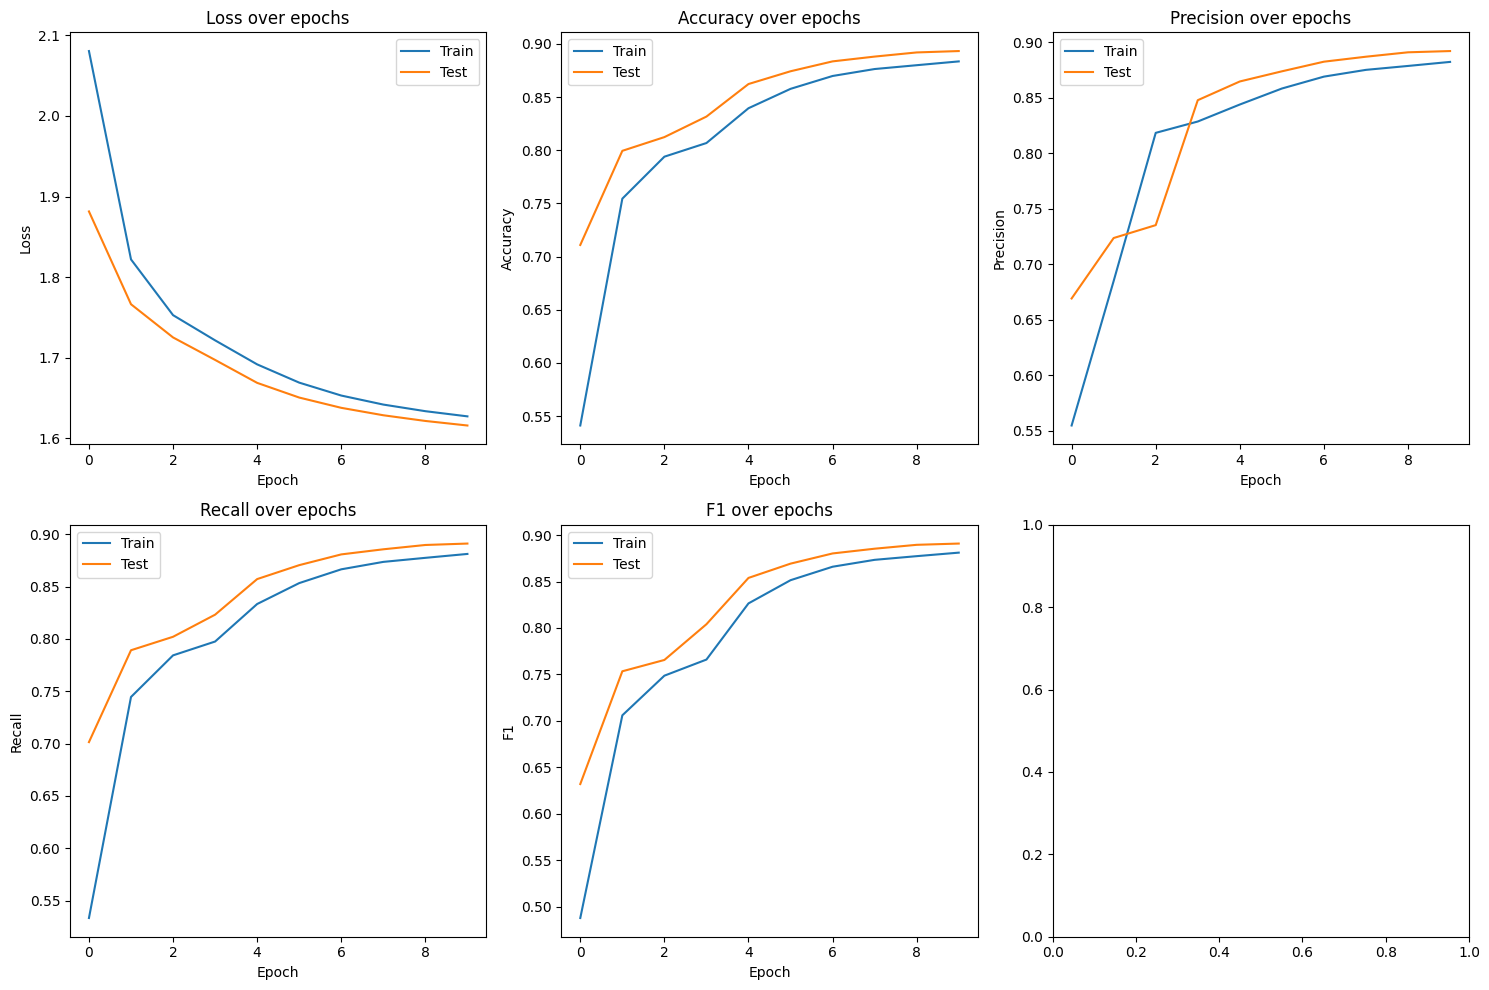

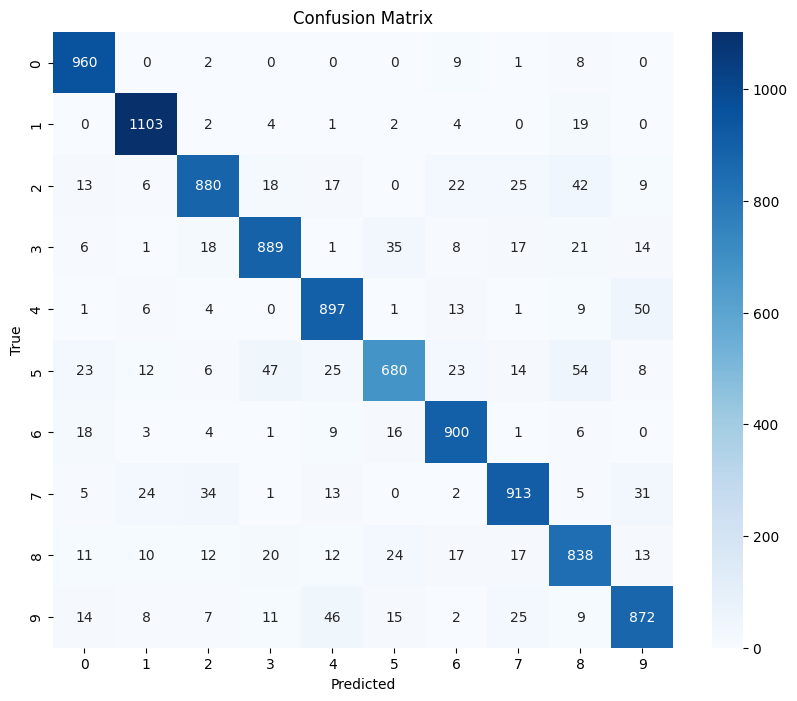

<Figure size 640x480 with 0 Axes>

In [ ]:
%run /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/main.py

### Bài 2: Xây dựng mô hình 3-layer MLP, hàm ReLU và hàm softmax làm activation function. Trong đó activation function cho 2 layer đầu là ReLU và activation function cho layer cuối là Softmax. Huấn luyện mô hình này sử dụng SGD làm optimizer và đánh giá trên các độ đo accuracy, precision, recall và F1-macro. Đánh giá kết quả của mô hình với từng chữ số.

## 2.1. Module 'perceptron_3_layer.py'

In [ ]:
%%writefile /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/perceptron_3_layer.py
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.notebook import tqdm

class MLP3Layer(nn.Module):
    def __init__(self, input_size=784, hidden_size1=128, hidden_size2=64, num_classes=10):
        """
        MLP 3 layer với ReLU và Softmax
        Args:
            input_size: Kích thước input (784 cho MNIST)
            hidden_size1: Số neurons trong hidden layer 1
            hidden_size2: Số neurons trong hidden layer 2
            num_classes: Số lượng classes (10 cho MNIST)
        """
        super(MLP3Layer, self).__init__()

        self.flatten = nn.Flatten()

        # Layer 1: Input -> Hidden 1
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()

        # Layer 2: Hidden 1 -> Hidden 2
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        # Layer 3: Hidden 2 -> Output
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Forward pass qua 3 layers
        """
        # Flatten input
        x = self.flatten(x)  # (batch, 1, 28, 28) -> (batch, 784)

        # Layer 1 với ReLU
        x = self.fc1(x)      # (batch, 784) -> (batch, hidden_size1)
        x = self.relu1(x)    # Áp dụng ReLU activation

        # Layer 2 với ReLU
        x = self.fc2(x)      # (batch, hidden_size1) -> (batch, hidden_size2)
        x = self.relu2(x)    # Áp dụng ReLU activation

        # Layer 3 với Softmax
        x = self.fc3(x)      # (batch, hidden_size2) -> (batch, num_classes)
        x = self.softmax(x)  # Áp dụng Softmax activation

        return x

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Huấn luyện model trong 1 epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc='Training'):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass và optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Lưu predictions và labels
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Tính metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    return {
        'loss': total_loss / len(train_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def evaluate(model, test_loader, criterion, device):
    """Đánh giá model trên tập test"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Tính metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    # Tính metrics cho từng class
    precision_per_digit, recall_per_digit, f1_per_digit, _ = \
        precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)

    return {
        'loss': total_loss / len(test_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_digit_metrics': {
            'precision': precision_per_digit,
            'recall': recall_per_digit,
            'f1': f1_per_digit
        }
    }

Overwriting /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/perceptron_3_layer.py


## 2.2. Module 'main_bai2.py'

In [ ]:
%%writefile /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/main_bai2.py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from mnist_dataset import MnistDataset, collate_fn
from perceptron_3_layer import MLP3Layer, train_epoch, evaluate
from google.colab import drive
from sklearn.metrics import confusion_matrix

def plot_training_history(train_history, test_history):
    """Vẽ đồ thị quá trình training"""
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        if idx < len(axes):
            axes[idx].plot(train_history[metric], label='Train', marker='o')
            axes[idx].plot(test_history[metric], label='Test', marker='s')
            axes[idx].set_title(f'{metric.capitalize()} over epochs')
            axes[idx].set_xlabel('Epoch')
            axes[idx].set_ylabel(metric.capitalize())
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)

    # Ẩn subplot cuối (vì chỉ có 5 metrics)
    axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

def print_final_results(test_metrics):
    """In kết quả chi tiết cho từng chữ số"""
    print("\n" + "="*60)
    print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH MLP 3-LAYER VỚI ReLU VÀ SOFTMAX")
    print("="*60)

    print("\nKết quả tổng quát:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision (macro): {test_metrics['precision']:.4f}")
    print(f"Recall (macro): {test_metrics['recall']:.4f}")
    print(f"F1-score (macro): {test_metrics['f1']:.4f}")

    print("\nKết quả chi tiết cho từng chữ số:")
    print("-"*60)
    print("Chữ số | Precision |  Recall  | F1-Score")
    print("-"*60)

    for digit in range(10):
        print(f"   {digit}   |   {test_metrics['per_digit_metrics']['precision'][digit]:.4f}  |  "
              f"{test_metrics['per_digit_metrics']['recall'][digit]:.4f}  |  "
              f"{test_metrics['per_digit_metrics']['f1'][digit]:.4f}")
    print("-"*60)

def plot_confusion_matrix(model, test_loader, device):
    """Vẽ confusion matrix"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['label']
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix - MLP 3-Layer')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def main():
    # Mount Google Drive
    drive.mount('/content/drive')

    # Đường dẫn dataset
    train_images_path = '/content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/train-images-idx3-ubyte.gz'
    train_labels_path = '/content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/train-labels-idx1-ubyte.gz'
    test_images_path = '/content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/t10k-images-idx3-ubyte.gz'
    test_labels_path = '/content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/t10k-labels-idx1-ubyte.gz'

    # Tạo dataset và dataloader
    print("Loading datasets...")
    train_dataset = MnistDataset(train_images_path, train_labels_path)
    test_dataset = MnistDataset(test_images_path, test_labels_path)

    train_loader = DataLoader(
        train_dataset,
        batch_size=64,  # Có thể tăng batch size cho MLP lớn hơn
        shuffle=True,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Thiết lập hyperparameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_size = 28 * 28
    hidden_size1 = 128  # Số neurons trong hidden layer 1
    hidden_size2 = 64   # Số neurons trong hidden layer 2
    num_classes = 10
    learning_rate = 0.01
    num_epochs = 15

    print("\n" + "="*60)
    print("BÀI 2: HUẤN LUYỆN MÔ HÌNH MLP 3-LAYER")
    print("="*60)
    print("\nThông số mô hình:")
    print(f"- Kiến trúc: {input_size} -> {hidden_size1} (ReLU) -> {hidden_size2} (ReLU) -> {num_classes} (Softmax)")
    print(f"- Learning rate: {learning_rate}")
    print(f"- Batch size: {train_loader.batch_size}")
    print(f"- Số epoch: {num_epochs}")
    print(f"- Device: {device}")
    print(f"- Optimizer: SGD")
    print("="*60)

    # Khởi tạo model
    model = MLP3Layer(input_size, hidden_size1, hidden_size2, num_classes).to(device)

    # In thông tin model
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTổng số tham số: {total_params:,}")
    print(f"Số tham số trainable: {trainable_params:,}")

    # Loss function và optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Lưu lịch sử training
    train_history = {metric: [] for metric in ['loss', 'accuracy', 'precision', 'recall', 'f1']}
    test_history = {metric: [] for metric in ['loss', 'accuracy', 'precision', 'recall', 'f1']}

    # Training loop
    print("\nBắt đầu huấn luyện...")
    print("="*60)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-"*60)

        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Training   - Loss: {train_metrics['loss']:.4f}, "
              f"Accuracy: {train_metrics['accuracy']:.4f}, "
              f"F1: {train_metrics['f1']:.4f}")

        # Evaluate
        test_metrics = evaluate(model, test_loader, criterion, device)
        print(f"Validation - Loss: {test_metrics['loss']:.4f}, "
              f"Accuracy: {test_metrics['accuracy']:.4f}, "
              f"F1: {test_metrics['f1']:.4f}")

        # Lưu metrics
        for metric in train_history:
            train_history[metric].append(train_metrics[metric])
            test_history[metric].append(test_metrics[metric])

    # Hiển thị kết quả cuối cùng
    print("\n" + "="*60)
    print("HUẤN LUYỆN HOÀN TẤT!")
    print("="*60)
    print_final_results(test_metrics)

    # Vẽ đồ thị training history
    print("\nVẽ đồ thị quá trình training...")
    plot_training_history(train_history, test_history)

    # Vẽ confusion matrix
    print("\nVẽ confusion matrix...")
    plot_confusion_matrix(model, test_loader, device)

    # So sánh kết quả best epoch
    best_epoch = np.argmax(test_history['accuracy']) + 1
    print(f"\nBest epoch: {best_epoch}")
    print(f"Best test accuracy: {max(test_history['accuracy']):.4f}")
    print(f"Best test F1-score: {test_history['f1'][best_epoch-1]:.4f}")

if __name__ == "__main__":
    main()

Writing /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/main_bai2.py


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading datasets...

Đang đọc file: /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/train-images-idx3-ubyte.gz
Reading files complete, shape: (60000, 28, 28)

Đang đọc file: /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/train-labels-idx1-ubyte.gz
Reading files complete, shape: (60000,)
Dataset loaded with 60000 samples

Đang đọc file: /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/t10k-images-idx3-ubyte.gz
Reading files complete, shape: (10000, 28, 28)

Đang đọc file: /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/t10k-labels-idx1-ubyte.gz
Reading files complete, shape: (10000,)
Dataset loaded with 10000 samples

BÀI 2: HUẤN LUYỆN MÔ HÌNH MLP 3-LAYER

Thông số mô hình:
- Kiến trúc: 784 -> 128 (ReLU) -> 64 (ReLU) -> 10 (Softmax)
- Learning rate: 0.01
- Batch size: 64
- Số epoch: 15
- Device: cpu
- Optimizer: SGD

Tổng số tham số: 109,386
Số tham số

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 2.3012, Accuracy: 0.1567, F1: 0.0818


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 2.2994, Accuracy: 0.2044, F1: 0.1036

Epoch 2/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 2.2969, Accuracy: 0.2113, F1: 0.1060


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 2.2931, Accuracy: 0.2147, F1: 0.1034

Epoch 3/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 2.2836, Accuracy: 0.1890, F1: 0.0837


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 2.2632, Accuracy: 0.1558, F1: 0.0618

Epoch 4/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 2.2317, Accuracy: 0.1943, F1: 0.0918


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 2.2034, Accuracy: 0.2534, F1: 0.1561

Epoch 5/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 2.1641, Accuracy: 0.3796, F1: 0.2947


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 2.1064, Accuracy: 0.5103, F1: 0.3954

Epoch 6/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 2.0300, Accuracy: 0.5331, F1: 0.4072


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.9540, Accuracy: 0.5524, F1: 0.4207

Epoch 7/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 1.9180, Accuracy: 0.5825, F1: 0.4750


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.8629, Accuracy: 0.6416, F1: 0.5337

Epoch 8/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 1.8250, Accuracy: 0.6900, F1: 0.6243


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.7684, Accuracy: 0.7618, F1: 0.7158

Epoch 9/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 1.7469, Accuracy: 0.7696, F1: 0.7245


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.7154, Accuracy: 0.7878, F1: 0.7419

Epoch 10/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 1.6998, Accuracy: 0.8063, F1: 0.7827


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.6698, Accuracy: 0.8410, F1: 0.8318

Epoch 11/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 1.6596, Accuracy: 0.8481, F1: 0.8425


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.6386, Accuracy: 0.8618, F1: 0.8573

Epoch 12/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 1.6349, Accuracy: 0.8625, F1: 0.8585


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.6191, Accuracy: 0.8722, F1: 0.8679

Epoch 13/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 1.6182, Accuracy: 0.8731, F1: 0.8698


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.6056, Accuracy: 0.8814, F1: 0.8781

Epoch 14/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 1.6061, Accuracy: 0.8802, F1: 0.8773


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.5954, Accuracy: 0.8859, F1: 0.8829

Epoch 15/15
------------------------------------------------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training   - Loss: 1.5967, Accuracy: 0.8852, F1: 0.8827


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 1.5885, Accuracy: 0.8881, F1: 0.8853

HUẤN LUYỆN HOÀN TẤT!

KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH MLP 3-LAYER VỚI ReLU VÀ SOFTMAX

Kết quả tổng quát:
Accuracy: 0.8881
Precision (macro): 0.8857
Recall (macro): 0.8859
F1-score (macro): 0.8853

Kết quả chi tiết cho từng chữ số:
------------------------------------------------------------
Chữ số | Precision |  Recall  | F1-Score
------------------------------------------------------------
   0   |   0.9265  |  0.9643  |  0.9450
   1   |   0.9600  |  0.9727  |  0.9663
   2   |   0.9001  |  0.8556  |  0.8773
   3   |   0.9022  |  0.8584  |  0.8798
   4   |   0.8516  |  0.9236  |  0.8862
   5   |   0.7902  |  0.7556  |  0.7725
   6   |   0.8814  |  0.9311  |  0.9056
   7   |   0.9128  |  0.9066  |  0.9097
   8   |   0.8418  |  0.8470  |  0.8444
   9   |   0.8903  |  0.8444  |  0.8667
------------------------------------------------------------

Vẽ đồ thị quá trình training...


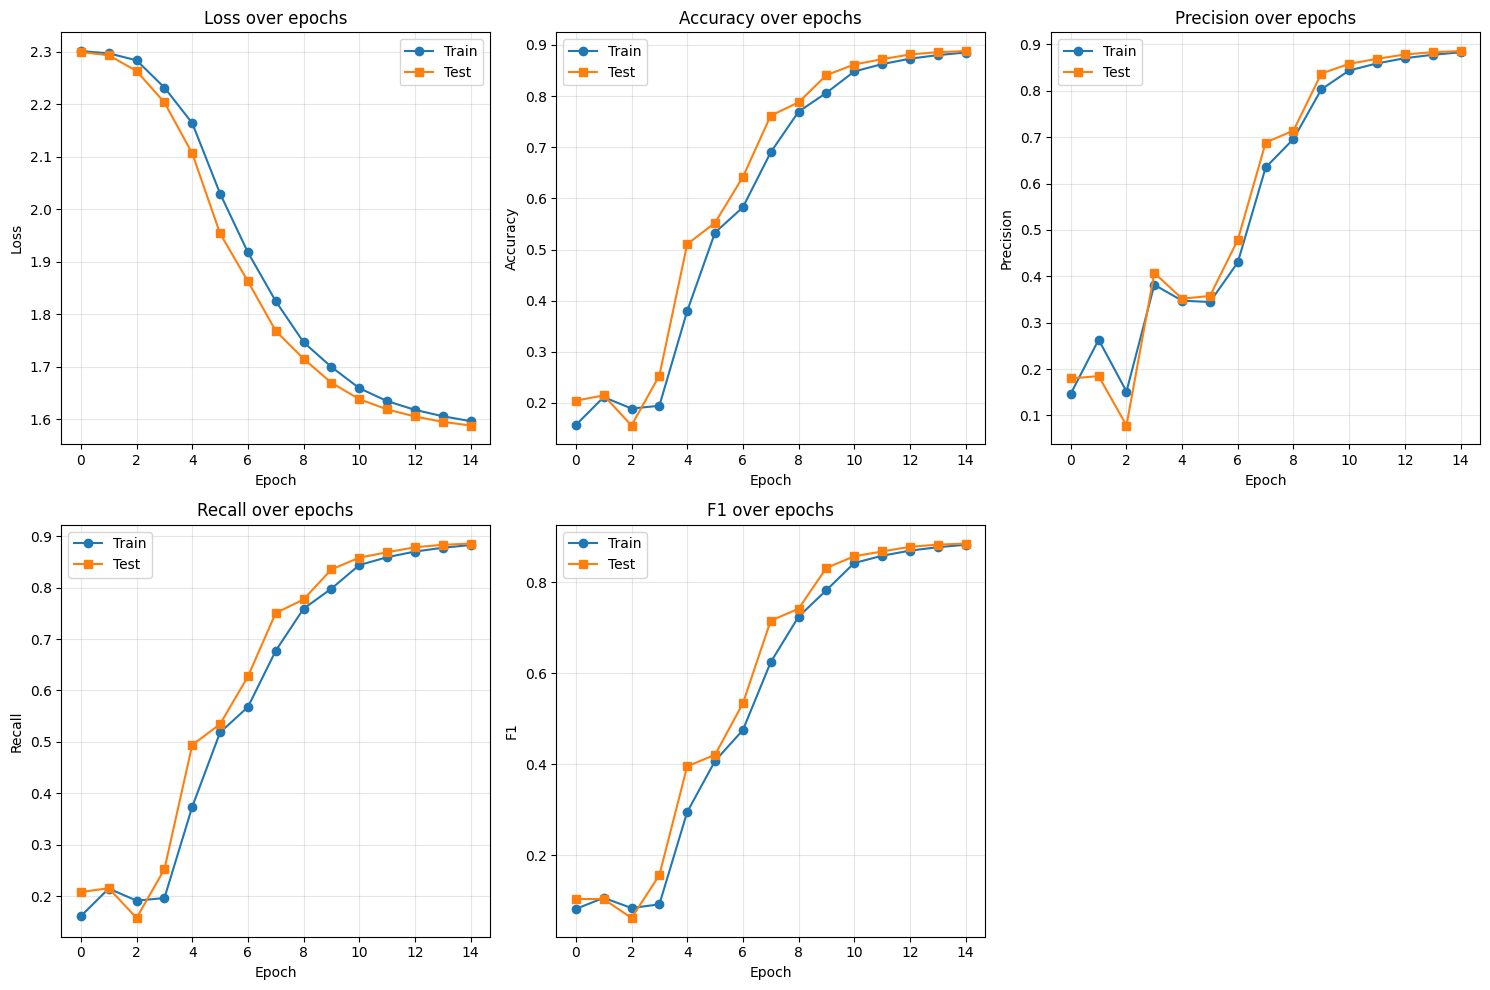


Vẽ confusion matrix...


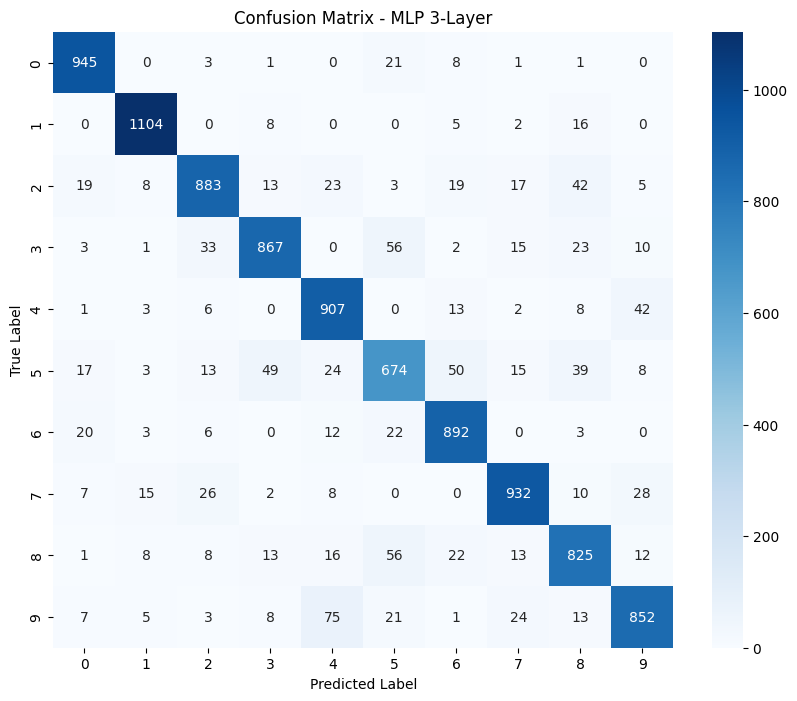


Best epoch: 15
Best test accuracy: 0.8881
Best test F1-score: 0.8853


<Figure size 640x480 with 0 Axes>

In [ ]:
%run /content/drive/MyDrive/Uni/Ki-5-Nam-3/DS201/Lab-1/main_bai2.py